## Sistema de Detecção de Fraudes em Transações

### Importar bibliotecas necessárias

In [3]:
# EDA e Visualização de Dados
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve

from lightgbm import LGBMClassifier, Dataset
import lightgbm as lgb

# Otimização
import optuna

# Utilitários
import joblib
from datetime import datetime
import math

### Abrir Base Transações

In [4]:
df_transacoes = pd.read_csv('./datasets/transacoes.csv')

### Visualizar primeiros e últimos registros

In [5]:
print("Primeiros registros:")
display(df_transacoes.head(10))

print("\nÚltimos registros:")
display(df_transacoes.tail(10))

Primeiros registros:


,ID_Transacao,ID_Cliente,Estabelecimento,Segmento,DataHora,Valor,Fraude
0,1ca88cf3-bd6d-438e-baff-861fa6c4a94e,a2db9269-561a-4e64-868d-cd167dd44ab1,Nogueira Pereira - ME,Loja Online,2024-11-09 21:06:16,332.66000,0
1,3d2481eb-c159-45c5-986e-fd524bf3a7be,3b830d7e-0054-4943-96ce-84b85e2cd1e4,Jesus,Oficina Mecânica,2023-06-22 05:26:52,17.01000,0
2,04151b5d-1d9c-49cd-8a09-2080bbcdeb1c,f737388d-52fc-47eb-8b44-8082beb8cc59,Dias S.A.,Posto de Combustível,2023-10-01 03:24:26,279.88000,1
3,ce10e2a4-59f1-49cf-adb1-abf6c01a08da,2fe8fdfa-d89f-46eb-8862-04a6b171fd43,Ribeiro,Oficina Mecânica,2024-06-30 22:17:53,124.92000,0
4,b02b67fc-f9fe-454d-85c9-ca75b18d062b,f6b635ff-4212-4948-af85-0c49379d4e93,Rezende,Posto de Combustível,2023-06-03 17:53:38,15.17000,0
5,e7fcc54d-8368-478c-a3cf-0ca138eb205c,67ee76c6-0a3d-43bf-b40d-0156375bd5b6,Fogaça,Mercado Livre,2024-04-25 11:22:46,15.17000,0
6,6e337cee-8a25-4779-85f4-3c31da8d019c,dbb8b653-f634-4dc5-85e4-d42583083bd1,Sousa da Mota S.A.,Mercado Livre,2023-12-22 19:55:36,133.63000,0
7,9f7a0d35-7cd4-4059-8cad-fde72e328bdd,386e8d48-f820-49a0-9435-399c6670a163,Mendonça S/A,Restaurante,2024-10-02 03:46:30,893.54000,0
8,1f47501b-3e9d-41dc-b3cf-8683c3f39e95,4e5af7db-8c74-4931-8daa-06277afacc45,Moraes - EI,Livraria,2023-03-27 21:13:16,11.43000,0
9,c3b0e137-15ef-4de7-913d-34d8ac906f34,8ac05907-52db-4ef1-a775-165c267dcee6,Siqueira e Filhos,Loja de Roupas,2023-12-20 02:26:59,38.52000,0



Últimos registros:


,ID_Transacao,ID_Cliente,Estabelecimento,Segmento,DataHora,Valor,Fraude
9990,7a6ef805-0c23-430a-abda-c514a603a289,c8c35dfd-2ecc-425c-9fee-17da90b8464a,da Cruz S/A,Farmácia,2024-12-24 06:20:13,112.21000,0
9991,421ccf9f-6087-4e05-ae85-0efb8448f638,d0d6822e-64a7-404a-8212-c1c3640b41aa,da Rocha,Restaurante,2023-07-04 02:25:24,25.27000,0
9992,45036637-5a83-4fed-b191-50bacc6d1849,fa94e471-fa55-4c3c-b2df-c63b2eddf6ca,da Paz - EI,Eletrônicos,2023-02-27 05:07:22,44.46000,0
9993,c1eea98f-58dd-4f86-8e3c-0ea1875122e7,36aea1af-d680-47e4-9c1a-67889b059c6d,Moraes - ME,Academia,2025-01-14 04:57:14,3.33000,0
9994,44df951e-ba3d-4cf8-9568-b5496493c2f9,2eff59e5-0d49-4687-9e09-00e18cd56f84,Rocha S.A.,Loja de Decoração,2024-10-24 10:51:20,84.19000,0
9995,1a502af5-82ff-459f-8a41-3b10782cf03f,242f4e94-7f2a-4557-a27a-9227cca55e83,Pereira - EI,Pet Shop,2023-02-23 01:08:37,95.71000,0
9996,04380454-7767-49bb-ae14-4c7db1054c3a,93a4477e-914b-48e0-9e0e-02f873d870f1,da Cunha Andrade Ltda.,Eletrônicos,2024-02-28 06:33:53,1.83000,0
9997,aa7d0fbe-0530-4f86-990d-10af6309e55c,427c01e9-9c4f-46a1-870a-eeff546c5f3e,Camargo,Posto de Combustível,2023-06-12 10:26:29,8.62000,0
9998,7fa1bd91-63c2-4307-a47e-1b35a6022d86,3b1daffb-dbec-4c7b-91d5-0f05c02a054d,Nunes Ltda.,Teatro,2024-05-09 06:42:40,36.41000,0
9999,eca7e8ff-28a2-4d77-9528-70209e4f2648,2eff59e5-0d49-4687-9e09-00e18cd56f84,da Luz S.A.,Loja de Roupas,2024-02-19 17:57:42,43.52000,0


In [6]:
# Remover colunas únicas
df_transacoes.drop(columns=['ID_Cliente', 'ID_Transacao'], axis=1, inplace=True)

### Feature Engineering

In [7]:
df_transacoes['DataHora'] = pd.to_datetime(df_transacoes['DataHora'])
df_transacoes['Hora'] = df_transacoes['DataHora'].dt.hour
df_transacoes['Dia_Semana'] = df_transacoes['DataHora'].dt.dayofweek
df_transacoes['Mes'] = df_transacoes['DataHora'].dt.month
df_transacoes = df_transacoes.drop('DataHora', axis=1)

### Cria lista de features e target

In [8]:
num_vars = df_transacoes.select_dtypes(include=['number']).columns
cat_vars = df_transacoes.select_dtypes(include=['object']).columns
target = 'Fraude'

### Estatísticas das variáveis numéricas

In [9]:
display(df_transacoes[num_vars].describe().T)

,count,mean,std,min,25%,50%,75%,max
Valor,10000.00000,110.04019,387.54919,0.18000,10.45000,25.62500,70.58750,11704.79000
Fraude,10000.00000,0.09440,0.29240,0.00000,0.00000,0.00000,0.00000,1.00000
Hora,10000.00000,10.92350,7.60233,0.00000,4.00000,10.00000,18.00000,23.00000
Dia_Semana,10000.00000,2.99630,2.00571,0.00000,1.00000,3.00000,5.00000,6.00000
Mes,10000.00000,6.52260,3.44007,1.00000,4.00000,7.00000,9.00000,12.00000


### Valores possíveis para variáveis categóricas

In [10]:
for var in cat_vars:
    print(f"\n{var}: {df_transacoes[var].nunique()} valores únicos")
    print(df_transacoes[var].value_counts().head(10))


Estabelecimento: 3156 valores únicos
Estabelecimento
Cavalcante    67
Sampaio       67
Fernandes     66
Pires         64
da Luz        62
Barros        61
Martins       59
Sousa         59
Lima          59
Nascimento    59
Name: count, dtype: int64

Segmento: 25 valores únicos
Segmento
Loja Online             434
Livraria                433
Posto de Combustível    424
Farmácia                424
Eletrônicos             420
Mercado Livre           414
Padaria                 411
Oficina Mecânica        411
Restaurante             406
Delivery                406
Name: count, dtype: int64


### Apresentar histograma das variáveis numéricas

In [11]:
# Número de colunas desejadas
num_cols = 2

# Calcular o número de linhas necessárias
num_rows = math.ceil(len(num_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=num_vars)

# Adicionar histogramas para cada variável numérica
for i, var in enumerate(num_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1
    fig.add_trace(
        go.Histogram(x=df_transacoes[var], name=var),
        row=row, col=col
    )

# Atualizar layout
fig.update_layout(
    height=300*num_rows,
    width=1200,
    title_text="Histogramas das Variáveis Numéricas",
    showlegend=False
)

fig.show()

### Gráfico de barras para variáveis categóricas

In [12]:
# Número de colunas desejadas
num_cols = 2

# Calcular o número de linhas necessárias
num_rows = math.ceil(len(cat_vars) / num_cols)

# Criar subplots
fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=cat_vars)

# Adicionar gráficos de barras para cada variável categórica
for i, var in enumerate(cat_vars):
    row = (i // num_cols) + 1
    col = (i % num_cols) + 1
    fig.add_trace(
        go.Bar(
            x=df_transacoes[var].value_counts().index[:10],
            y=df_transacoes[var].value_counts().values[:10],
            name=var
        ),
        row=row, col=col
    )
    
fig.show()

### Boxplot e histograma entre features e target

In [13]:
# Analisando relação entre variáveis explicativas e targets
for col in num_vars:
    fig = px.box(df_transacoes, x=target, y=col, title=f"{col} por {target}")
    fig.show()

for col in cat_vars:
    fig = px.histogram(df_transacoes, x=col, color=target, barmode='group', title=f"{col} por {target}")
    fig.show()

### Matriz de correlação

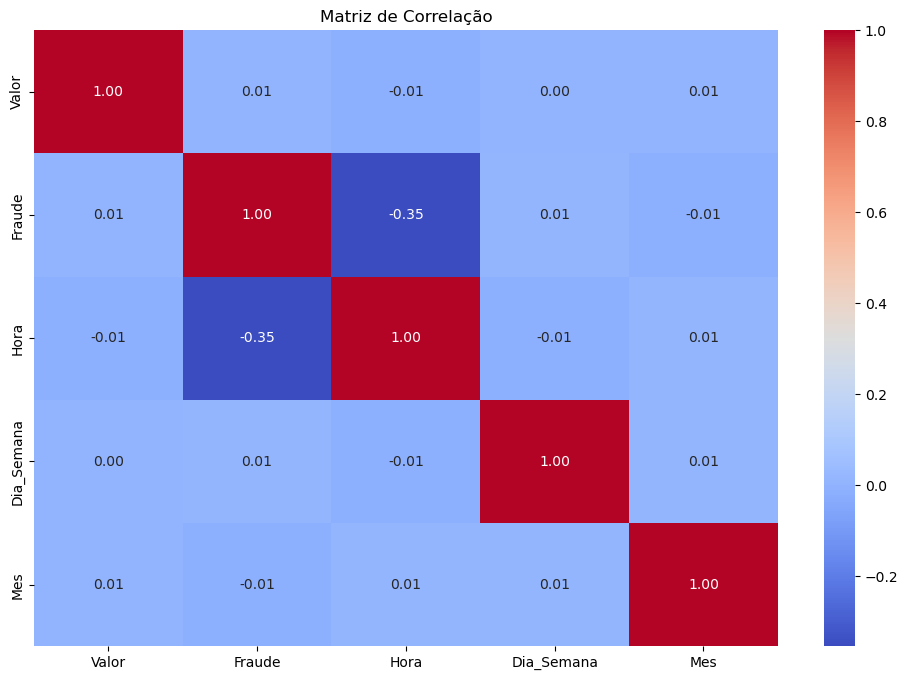

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_transacoes[num_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

### Testes de hipóteses entre Target Categórica e Numéricas (ANOVA)

In [15]:
for num_col in num_vars:
    groups = [df_transacoes[df_transacoes[target] == val][num_col] for val in df_transacoes[target].unique()]
    stat, p = f_oneway(*groups)
    print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
          f"ANOVA entre {num_col} e {target}: p-valor = {p}")

ANOVA entre Valor e Fraude: p-valor = 0.5304523147441481
ANOVA entre Fraude e Fraude: p-valor = 0.0
ANOVA entre Hora e Fraude: p-valor = 2.335008397558635e-291
ANOVA entre Dia_Semana e Fraude: p-valor = 0.3799386946687383
ANOVA entre Mes e Fraude: p-valor = 0.17847355723925032


c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: ConstantInputWarning:

Each of the input arrays is constant; the F statistic is not defined or infinite



### Preparação dos dados

In [16]:
selected_features = ['Hora', 'Valor']
X = df_transacoes[selected_features]
y = df_transacoes[target]

### Treinar LightGBM com Validação Cruzada

In [17]:
# Parâmetros do LightGBM
params = {
    'objective': 'binary',
    'metric': 'average_precision',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'verbose':0,
    'is_unbalance': True  # Ou: scale_pos_weight
}

In [18]:
def treinar_modelo(params, min_precision = 0.5):
    # Configurar validação cruzada
    n_splits = 5
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Listas para armazenar probabilidades e rótulos
    y_true_all = []
    y_proba_all = []

    # Validação cruzada
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Dataset do LightGBM
        train_data = Dataset(X_train, label=y_train)
        val_data = Dataset(X_val, label=y_val)

        # Treinar modelo
        model = lgb.train(params, train_data, valid_sets=[val_data])

    # Treinar modelo
        model = lgb.train(params, train_data, valid_sets=[val_data])

        # Prever probabilidades no conjunto de validação
        y_proba = model.predict(X_val)

        # Armazenar resultados
        y_true_all.extend(y_val)
        y_proba_all.extend(y_proba)

    # Converter listas para arrays
    y_true_all = np.array(y_true_all)
    y_proba_all = np.array(y_proba_all)

    # Calcular a curva Precision–Recall
    precision, recall, thresholds = precision_recall_curve(y_true_all, y_proba_all)

    # Encontrar o melhor threshold
    best_idx = np.argmax((precision >= min_precision) & (recall == np.max(recall[precision >= min_precision])))
    best_threshold = thresholds[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]

    return best_threshold, best_precision, best_recall, precision, recall

best_threshold, best_precision, best_recall, precision, recall = treinar_modelo(params)

print(f"Melhor threshold: {best_threshold:.4f}")
print(f"Precision no melhor threshold: {best_precision:.4f}")
print(f"Recall no melhor threshold: {best_recall:.4f}")

Melhor threshold: 0.9204
Precision no melhor threshold: 0.5000
Recall no melhor threshold: 0.0466


### Apresentar Métricas

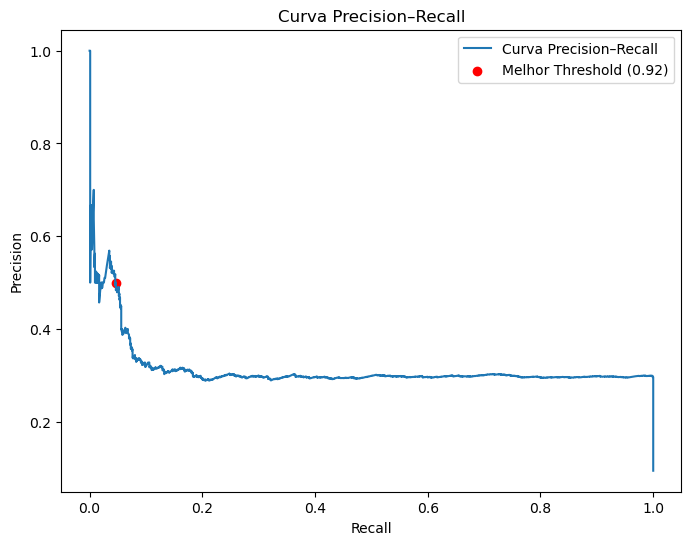

In [19]:
# Plotar a curva Precision–Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Curva Precision–Recall')
plt.scatter(best_recall, best_precision, color='red', label=f'Melhor Threshold ({best_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall')
plt.legend()
plt.show()

In [20]:
# Treinar modelo final com todos os dados
final_model = lgb.train(params, Dataset(X, label=y))

# Fazer previsões com o melhor threshold
y_proba_final = final_model.predict(X)
y_pred_final = (y_proba_final >= best_threshold).astype(int)
print(f"\nAUC–PR: {average_precision_score(y, y_proba_final):.2f}")


AUC–PR: 0.54



Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9056
           1       0.71      0.06      0.11       944

    accuracy                           0.91     10000
   macro avg       0.81      0.53      0.53     10000
weighted avg       0.89      0.91      0.87     10000



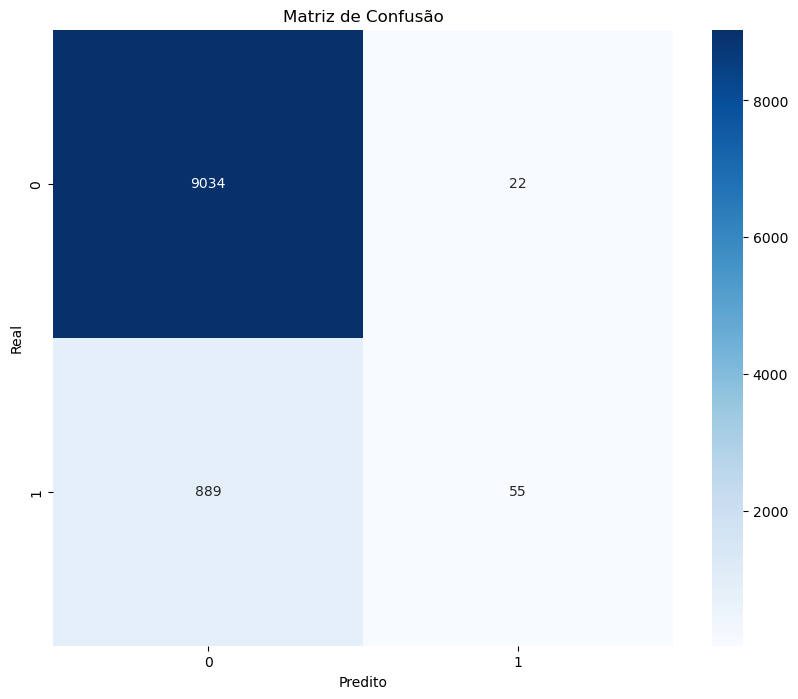

In [21]:
# Avaliar métricas finais
from sklearn.metrics import classification_report
print("\nRelatório de Classificação Final:")
print(classification_report(y, y_pred_final))

# Criar matriz de confusão
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

### Otimização com Optuna

In [22]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'average_precision',  # AUC-PR
        'boosting_type': 'gbdt',
        'verbose':0,
        'is_unbalance': True
    }

    min_precision = trial.suggest_float('min_precision', 0.3, 0.7)

    best_threshold, best_precision, best_recall, precision, recall = treinar_modelo(params, min_precision)

    return best_recall

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print(f"Melhores parâmetros: {best_params}")

[I 2025-05-12 23:48:10,544] A new study created in memory with name: no-name-64772ef4-c5da-4cce-8ca8-7550216c733c
[I 2025-05-12 23:48:14,444] Trial 0 finished with value: 0.05614406779661017 and parameters: {'min_precision': 0.441264531649102}. Best is trial 0 with value: 0.05614406779661017.
[I 2025-05-12 23:48:18,414] Trial 1 finished with value: 0.05190677966101695 and parameters: {'min_precision': 0.483805972817915}. Best is trial 0 with value: 0.05614406779661017.
[I 2025-05-12 23:48:22,758] Trial 2 finished with value: 0.05190677966101695 and parameters: {'min_precision': 0.4809053154920265}. Best is trial 0 with value: 0.05614406779661017.
[I 2025-05-12 23:48:27,173] Trial 3 finished with value: 0.007415254237288136 and parameters: {'min_precision': 0.6778996109340519}. Best is trial 0 with value: 0.05614406779661017.
[I 2025-05-12 23:48:31,418] Trial 4 finished with value: 0.03919491525423729 and parameters: {'min_precision': 0.5289571510315315}. Best is trial 0 with value: 0.0

Melhores parâmetros: {'min_precision': 0.30017972108366875}


### Treino do Melhor Modelo e Avaliação

In [23]:
best_threshold, best_precision, best_recall, precision, recall = treinar_modelo(params, study.best_params['min_precision'])
print(f"Melhor threshold: {best_threshold:.4f}")
print(f"Precision no melhor threshold: {best_precision:.4f}")
print(f"Recall no melhor threshold: {best_recall:.4f}")

# Treinar modelo final com todos os dados
final_model = lgb.train(params, Dataset(X, label=y))

# Fazer previsões com o melhor threshold
y_proba_final = final_model.predict(X)
y_pred_final = (y_proba_final >= best_threshold).astype(int)
print(f"\nAUC-PR: {average_precision_score(y, y_proba_final):.2f}")

Melhor threshold: 0.6896
Precision no melhor threshold: 0.3003
Recall no melhor threshold: 0.7468

AUC-PR: 0.54


In [ ]:
# Calcular e exibir métricas
print("\nRelatório de Classificação:")
print(classification_report(y, y_pred_final))

# Criar matriz de confusão
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

### Salvar Modelo

In [24]:
joblib.dump(final_model, './modelo_antifraude.pkl')

['./modelo_antifraude.pkl']